In [1]:
# !pip install fastai
# !pip install transformers

In [2]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [4]:
path = './poems'
# from google.colab import drive
# drive.mount('/content/drive')


In [5]:
# path="drive/MyDrive/poem/poems"
# !ls drive/MyDrive/poem/poems

In [6]:
poems = get_text_files(path, folders = ['carol','haiku'])
print("There are",len(poems),"poems in the dataset")

There are 198 poems in the dataset


In [7]:
ballads = get_text_files(path, folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [8]:
txt = poems[0].open().read(); #read the first file
print(txt)

Silent Night
Holy Night
Bombs in flight
Birds big fright
Men will fight
For their right
Putting might
First in sight
Jesus slight
Small in height
Has a bite
Like a knight
Angels not tight
Fly like a kite
Silent Night
Holy Night


## Prepare the data

In [9]:
ballads = L(o.open().read() for o in ballads[:50]) # to make things easy we will gather all texts in one numpy array
ballads


(#50) ['The burden of hard hitting. Slug away\nLike Honus Wagner or like Tyrus Cobb.\nElse fandom shouteth: "Who said you could play?\nBack to the jasper league, you minor slob!"\nSwat, hit, connect, line out, goet on the job.\nElse you shall feel the brunt of fandom\'s ire\nBiff, bang it, clout it, hit it on the knob -\nThis is the end of every fan\'s desire.\nThe burden of good pitching. Curved or straight.\nOr in or out, or haply up or down,\nTo puzzle him that standeth by the plate,\nTo lessen, so to speak, his bat-renown:\nLike Christy Mathewson or Miner Brown,\nSo pitch that every man can but admire\nAnd offer you the freedom of the town -\nThis is the end of every fan\'s desire.\nThe burden of loud cheering. O the sounds!\nThe tumult and the shouting from the throats\nOf forty thousand at the Polo Grounds\nSitting, ay, standing sans their hats and coats.\nA mighty cheer that possibly denotes\nThat Cub or Pirate fat is in the fire;\nOr, as H. James would say, We\'ve got their goa

In [10]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)
len(all_ballads)

50

In [11]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [12]:
splits = [range_of(20), range(50)] # use a 70/30 split

tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [13]:
show_at(tls.train, 0)

The burden of hard hitting. Slug away
Like Honus Wagner or like Tyrus Cobb.
Else fandom shouteth: "Who said you could play?
Back to the jasper league, you minor slob!"
Swat, hit, connect, line out, goet on the job.
Else you shall feel the brunt of fandom's ire
Biff, bang it, clout it, hit it on the knob -
This is the end of every fan's desire.
The burden of good pitching. Curved or straight.
Or in or out, or haply up or down,
To puzzle him that standeth by the plate,
To lessen, so to speak, his bat-renown:
Like Christy Mathewson or Miner Brown,
So pitch that every man can but admire
And offer you the freedom of the town -
This is the end of every fan's desire.
The burden of loud cheering. O the sounds!
The tumult and the shouting from the throats
Of forty thousand at the Polo Grounds
Sitting, ay, standing sans their hats and coats.
A mighty cheer that possibly denotes
That Cub or Pirate fat is in the fire;
Or, as H. James would say, We've got their goats -
This is the end of every fan'

In [14]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


In [15]:
dls.show_batch(max_n=2)

,text,text_
0,"Bird of the bitter bright grey golden morn\nScarce risen upon the dusk of dolorous years,\nFirst of us all and sweetest singer born\nWhose far shrill note the world of new men hears\nCleave the cold shuddering shade as twilight clears;\nWhen song new-born put off the old world's attire\nAnd felt its tune on her changed lips expire,\nWrit foremost on the roll of them that came\nFresh girt for service of the latter lyre,\nVillon, our sad bad glad mad brother's name!\nAlas the joy, the sorrow, and the scorn,\nThat clothed thy life with hopes and sins and fears,\nAnd gave thee stones for bread and tares for corn\nAnd plume-plucked gaol-birds for thy starveling peers\nTill death clipt close their flight with shameful shears;\nTill shifts came short and loves were hard to hire,\nWhen lilt of song nor twitch of twangling wire\nCould buy thee bread or kisses; when light fame\nSpurned like a ball and haled through brake and briar,\nVillon, our","of the bitter bright grey golden morn\nScarce risen upon the dusk of dolorous years,\nFirst of us all and sweetest singer born\nWhose far shrill note the world of new men hears\nCleave the cold shuddering shade as twilight clears;\nWhen song new-born put off the old world's attire\nAnd felt its tune on her changed lips expire,\nWrit foremost on the roll of them that came\nFresh girt for service of the latter lyre,\nVillon, our sad bad glad mad brother's name!\nAlas the joy, the sorrow, and the scorn,\nThat clothed thy life with hopes and sins and fears,\nAnd gave thee stones for bread and tares for corn\nAnd plume-plucked gaol-birds for thy starveling peers\nTill death clipt close their flight with shameful shears;\nTill shifts came short and loves were hard to hire,\nWhen lilt of song nor twitch of twangling wire\nCould buy thee bread or kisses; when light fame\nSpurned like a ball and haled through brake and briar,\nVillon, our"
1,"the day was, the likeness of the night;\nThis is the end of every man's desire.\nL'ENVOY\nPrinces, and ye whom pleasure quickeneth,\nHeed well this rhyme before your pleasure tire;\nFor life is sweet, but after life is death.\nThis is the end of every man's desire.Those who sailed at dawn\nbut will never return\nleft their trace on a wave--\na shell fell to the bottom of the sea\nbeautiful as lips turned to stone\nthose who walked on a sandy road\nbut could not reach the shuttered windows\nthough they already saw the roofs--\nthey have found shelter in a bell of air\nbut those who leave behind only\na room grown cold a few books\nan empty inkwell white paper--\nin truth they have not completely died\ntheir whisper travels through thickets of wallpaper\ntheir level head still lives in the ceiling\ntheir paradise was made of air\nof water lime and earth an angel of wind\nwill pulverize the body in its hand\nthey will be\ncarried over the","day was, the likeness of the night;\nThis is the end of every man's desire.\nL'ENVOY\nPrinces, and ye whom pleasure quickeneth,\nHeed well this rhyme before your pleasure tire;\nFor life is sweet, but after life is death.\nThis is the end of every man's desire.Those who sailed at dawn\nbut will never return\nleft their trace on a wave--\na shell fell to the bottom of the sea\nbeautiful as lips turned to stone\nthose who walked on a sandy road\nbut could not reach the shuttered windows\nthough they already saw the roofs--\nthey have found shelter in a bell of air\nbut those who leave behind only\na room grown cold a few books\nan empty inkwell white paper--\nin truth they have not completely died\ntheir whisper travels through thickets of wallpaper\ntheir level head still lives in the ceiling\ntheir paradise was made of air\nof water lime and earth an angel of wind\nwill pulverize the body in its hand\nthey will be\ncarried over the meadows"


## Fine-tuning the model

In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [18]:
learn.validate()

c:\Users\shelk\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
c:\Users\shelk\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [4.350619792938232,77.52649688720703]

SuggestedLRs(valley=0.00015848931798245758)

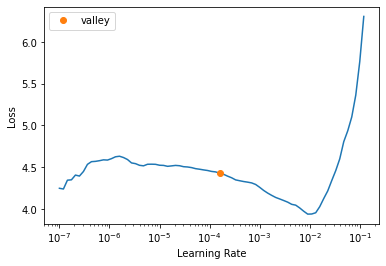

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.431156,4.214176,67.638420,04:27


## Poem Generation

In [21]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]

In [22]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous."

"I don't know what you're talking about," she said. "I'm not sure I'm going to be able to keep up with you. I've got a lot of friends, and they're all over the place, so I'll have to take care


In [23]:
prompt = "heartbreak"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
heartbreak.

"I don't know what you're talking about," he said, "but I'm sure you've got something to tell me. I've never seen anything like it before. It's a beautiful thing to see, and it's so beautiful that I can't help but


In [2]:
import pickle

In [25]:
filename = "model.sav"
pickle.dump(learn.model, open(filename, "wb"))

In [4]:
filename = "model.sav"
model_saved = pickle.load(open(filename, "rb"))
# model_saved

# use the saved model

In [14]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [15]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [16]:
path = './poems'

In [17]:
ballads = get_text_files(path, folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [18]:
ballads = L(o.open().read() for o in ballads[:50])

In [19]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)
len(all_ballads)

50

In [20]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [22]:
prompt = ""
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = model_saved.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
roses and thorns.

"I am not afraid," said he, "but I am afraid that I shall not be able to make my way to the place where I came from. I have not the courage to go there, but I must go to my own house, and I
